# Technical Test Descartes Underwriting
 Victor Tempé

TARGET_FLAG, the target of the project, is a binary variable. It is a supervied learning binary classification setting. After exploring and and processing the data, several models will be compared. The best one will be used to predict the target of the test set.

#### Imports

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

### Data Exploration

##### Load data

In [131]:
df = pd.read_csv("data/train_auto.csv", index_col=0)
print('df shape :', df.shape)


df shape : (8161, 25)


In [132]:

print('head of first 12 columns')
display(df.iloc[:5,:12])

print('head of the remaining columns')
display(df.iloc[:5,12:])

head of first 12 columns


,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION
INDEX,,,,,,,,,,,,
1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD
2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School
4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School
5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School
6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,PhD


head of the remaining columns


,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,
1,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
2,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
4,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
5,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
6,Doctor,36,Private,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


At this stage, we can already notice :  
* typos  
* $ string values that need to be converted to numeric values  
* there are numerical values and categories for each column. Tree based models can be used to make predictions based on those two types of input data. Another strategy could be to only use numerical values.

#### Label distribution

ratio of 1 :  0.26
ratio of 0 :  0.74


<AxesSubplot:>

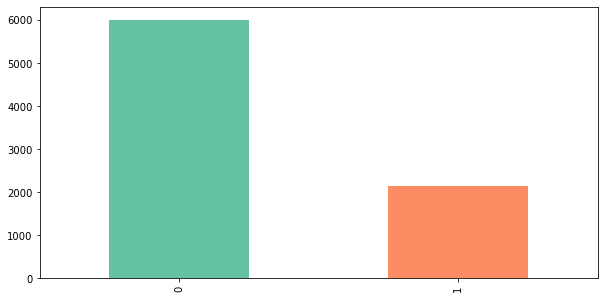

In [133]:
# compute the label ratio values
ratio_of_target_1 = (df['TARGET_FLAG']== 1).sum() / len(df)
ratio_of_target_1 = round(ratio_of_target_1, 2)
print('ratio of 1 : ', ratio_of_target_1)
print('ratio of 0 : ', 1 - ratio_of_target_1) 

# plot the number of label belonging to each value
df['TARGET_FLAG'].value_counts().plot(kind="bar", figsize=(10, 5), color=sns.color_palette('Set2'))




The labels in the dataset are slightly imbalanced.

##### Data overall statistics

In [134]:
#### convert $ to numeric before displaying general statistics
list_dollar_columns = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']
# convert columns string
df[list_dollar_columns] = df[list_dollar_columns].astype('str')
# remove $ and , and convert to float
df[list_dollar_columns] = df[list_dollar_columns].replace('[$,]','', regex=True).astype('float64')

# display statistics
round(df.describe(), 2)

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CAR_AGE
count,8161.00,8161.00,8161.00,8155.00,8161.00,7707.00,7716.00,7697.00,8161.00,8161.00,8161.00,8161.00,8161.00,8161.00,7651.00
mean,0.26,1504.32,0.17,44.79,0.72,10.50,61898.09,154867.29,33.49,15709.90,5.35,4037.08,0.80,1.70,8.33
std,0.44,4704.03,0.51,8.63,1.12,4.09,47572.68,129123.77,15.91,8419.73,4.15,8777.14,1.16,2.15,5.70
min,0.00,0.00,0.00,16.00,0.00,0.00,0.00,0.00,5.00,1500.00,1.00,0.00,0.00,0.00,-3.00
25%,0.00,0.00,0.00,39.00,0.00,9.00,28097.00,0.00,22.00,9280.00,1.00,0.00,0.00,0.00,1.00
50%,0.00,0.00,0.00,45.00,0.00,11.00,54028.00,161160.00,33.00,14440.00,4.00,0.00,0.00,1.00,8.00
75%,1.00,1036.00,0.00,51.00,1.00,13.00,85986.00,238724.00,44.00,20850.00,7.00,4636.00,2.00,3.00,12.00
max,1.00,107586.14,4.00,81.00,5.00,23.00,367030.00,885282.00,142.00,69740.00,25.00,57037.00,5.00,13.00,28.00


Except the negative value in CAR_AGE, it seems there is no inconsistent values


#### Missing values

In [135]:
nb_rows = len(df)
nb_rows_with_nan = df.isnull().any(axis=1).sum()

print('number of rows :', nb_rows)
print('number of rows with at least one NaN :', nb_rows_with_nan )

print('ratio of NaN rows  : ',  round( nb_rows_with_nan / nb_rows, 2))
print('ratio of complete rows  : ',  round( (nb_rows - nb_rows_with_nan) / nb_rows, 2))

number of rows : 8161
number of rows with at least one NaN : 2116
ratio of NaN rows  :  0.26
ratio of complete rows  :  0.74


One quarter of the rows has at least one NaN value, let's see which features are concerned 

,nb of NaN
TARGET_FLAG,0
TARGET_AMT,0
KIDSDRIV,0
AGE,6
HOMEKIDS,0
YOJ,454
INCOME,445
PARENT1,0
HOME_VAL,464
MSTATUS,0


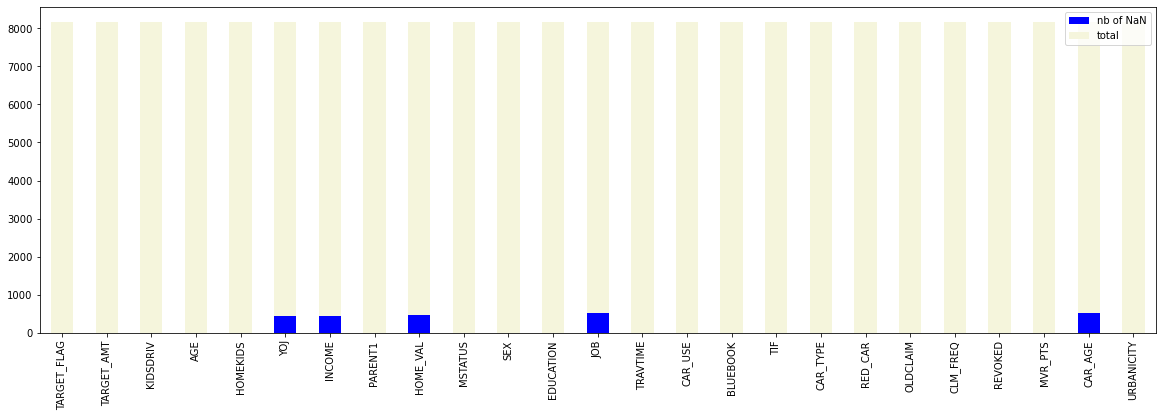

In [128]:
#### plot the number of missing values per column
col_na_count = []
col_no_na_count = []
for col in df.columns:
    col_na_count.append(df[col].isna().sum())
    col_no_na_count.append(len(df[col]) - df[col].isna().sum())

missing_values_df = pd.DataFrame({'nb of NaN' : col_na_count, 'total' : col_no_na_count}, index=df.columns)
missing_values_df.plot.bar(stacked=True, figsize=(20, 6), color={'total' : 'beige', 'nb of NaN' : 'blue'})
pd.DataFrame(missing_values_df['nb of NaN'])

Above, 5 columns have been identified as having missing values for a total of 2405. But 2116 rows had missing values, this means that a few rows have more than 2 missing values

nb of rows with 1 missing value :  1848
nb of rows with 2 missing values :  248
nb of rows with 3 missing values :  19
nb of rows with 4 missing values :  1
nb of rows with more than 4 missing values :  0


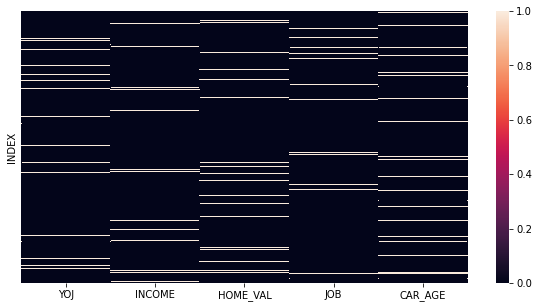

In [20]:
print('nb of rows with 1 missing value : ', len(df[ df.isnull().sum(axis=1)==1]) )
print('nb of rows with 2 missing values : ', len(df[ df.isnull().sum(axis=1)==2]) )
print('nb of rows with 3 missing values : ', len(df[ df.isnull().sum(axis=1)==3]) )
print('nb of rows with 4 missing values : ', len(df[ df.isnull().sum(axis=1)==4]) )
print('nb of rows with more than 4 missing values : ', len(df[ df.isnull().sum(axis=1)>4]) )

# missing values per row
plt.figure(figsize=(10,5))
sns.heatmap(df[['YOJ', 'INCOME', 'HOME_VAL', 'JOB', 'CAR_AGE']].isnull(), yticklabels=False)
plt.show()

Strategy to deal with missing values :
* YOJ, INCOME, HOME_VAL, CAR_AGE, AGE : take a median or a frequent value
* JOB : create an 'unknown' class

#### Features distributions

Here, the features distributions will be plotted column-wise. Given the labels imbalance, the ratio of each label belonging to a class is plotted instead of the actual number of labels for categorical columns. The hist density is used is continuous variables.
The goal is to determine if there are some features that make it possible to discriminate between the two labels. The plots will also allow to examine the different classes. 

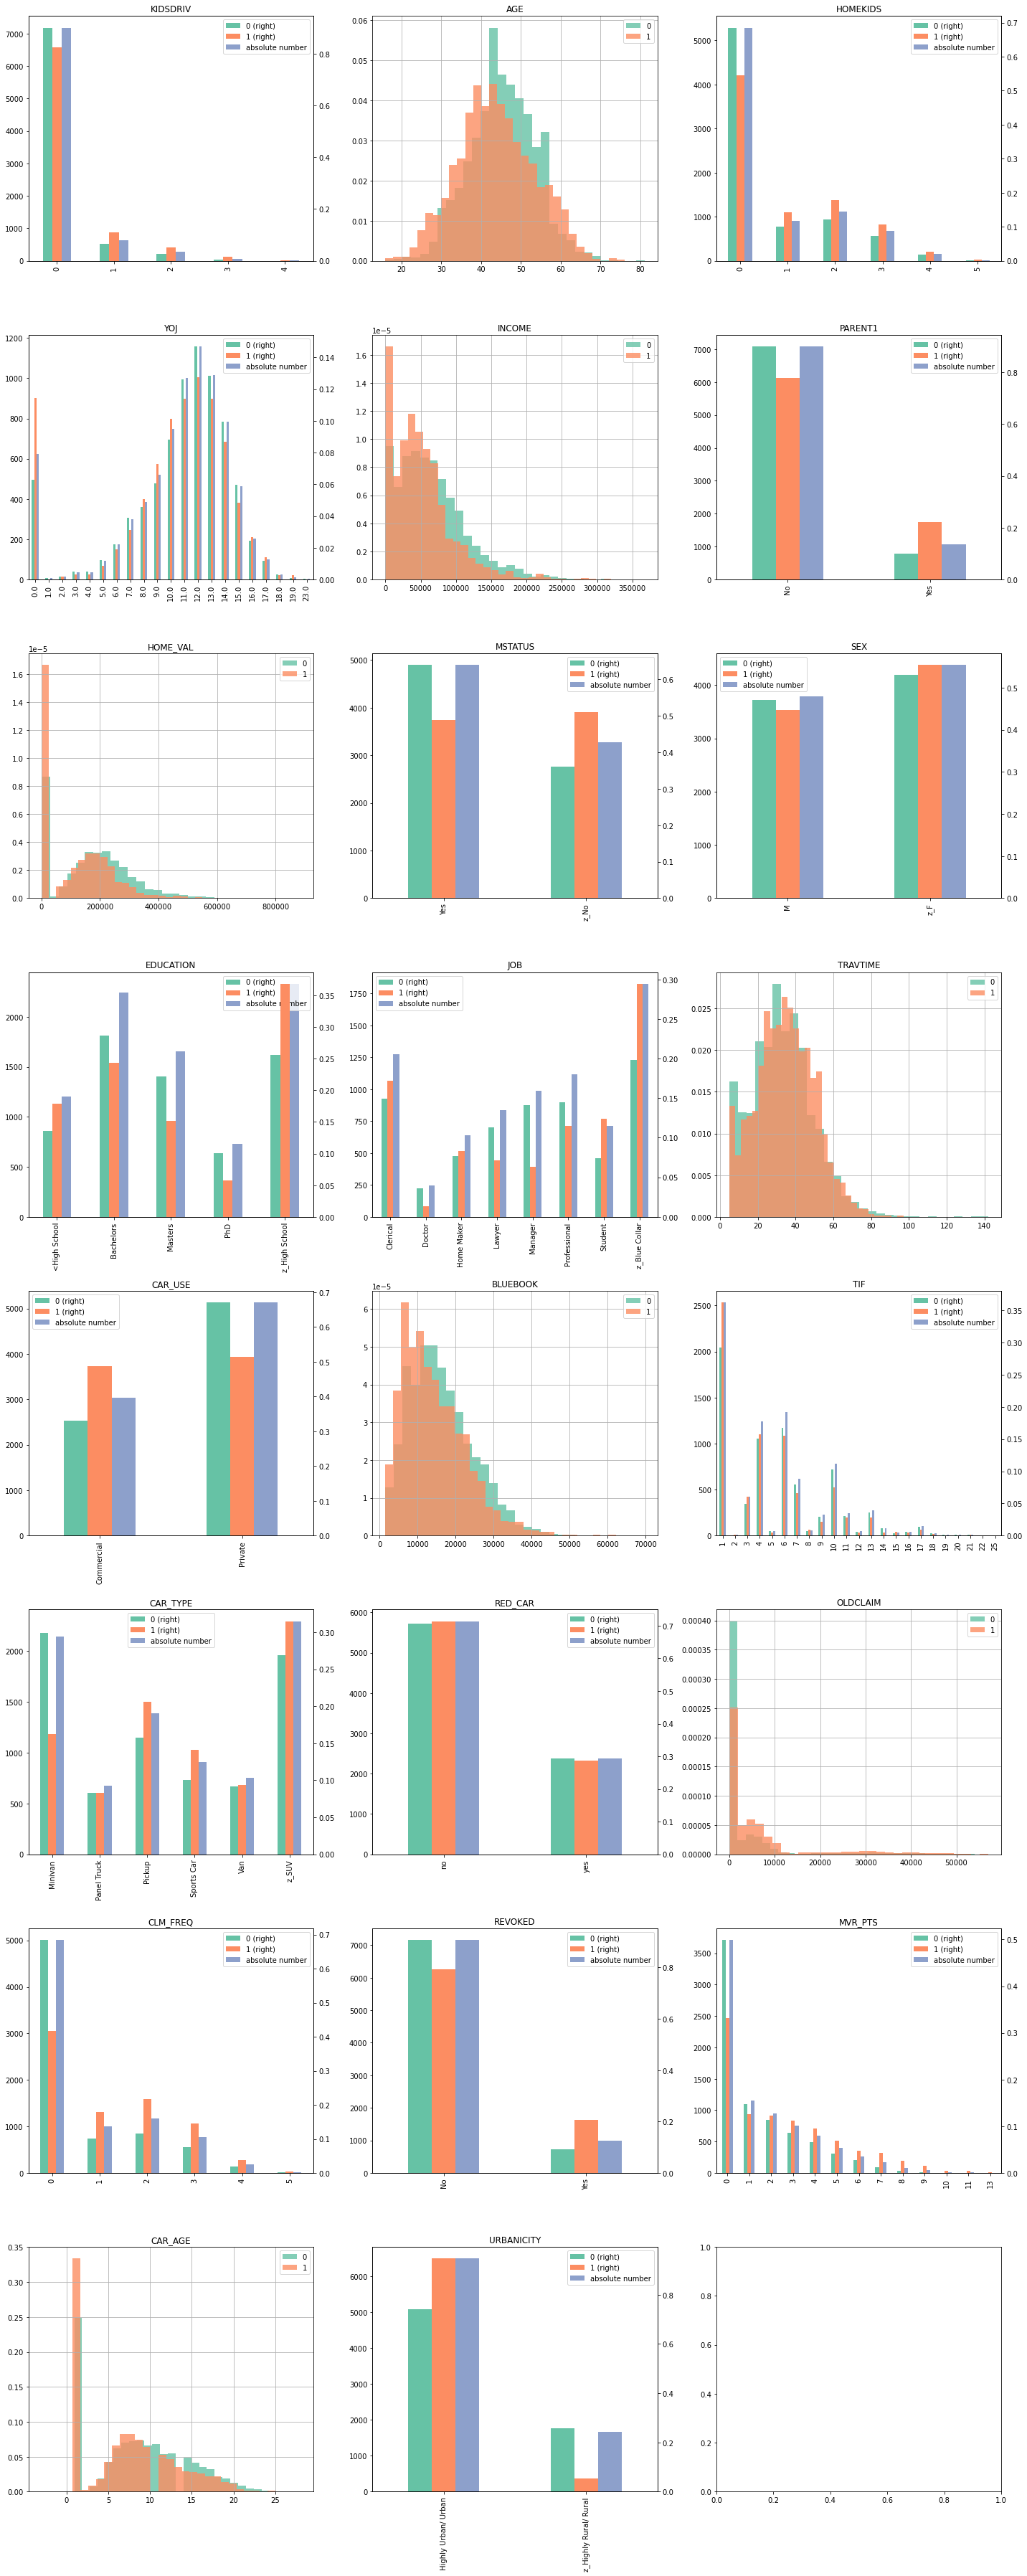

In [138]:
def plot_features(df):
    # numerical columns, they will be plotted as hist
    list_numerical_columns = list_dollar_columns + ['AGE', 'TRAVTIME', 'CAR_AGE']
    # keep all the columns except those with TARGET in their name
    list_columns_to_plot = [col for col in df.columns if 'TARGET' not in col]

    # extract 2 dataframes accodring to the label value
    df_0 = df[df['TARGET_FLAG']==0]
    df_1 = df[df['TARGET_FLAG']==1]


    fig, axes = plt.subplots(8, 3, figsize=(20, 50))
    # one plot per column
    for idx_col, col in enumerate(list_columns_to_plot):
        # indeces in the subplot grid
        row_plot_idx = idx_col // 3
        col_plot_idx = idx_col % 3
        
        ###################################################
        #### process for categorical values (bar plot) ####
        if col not in list_numerical_columns and 'TARGET' not in col:
            # get the count of each label in each column
            idx_list = sorted(list(pd.DataFrame(df[col].value_counts()).index))
            curr_df = pd.DataFrame({'0' : np.nan, '1' : np.nan}, index=idx_list)
            df_count_target0 = pd.DataFrame(df_0[col].value_counts())
            df_count_target1 = pd.DataFrame(df_1[col].value_counts())
            df_count_all = pd.DataFrame(df[col].value_counts())
            # fill the new dataframe
            for idx in idx_list:
                if idx in list(df_count_target0.index):
                    curr_df.loc[idx, '0'] = df_count_target0.loc[idx, col]
                if idx in list(df_count_target1.index):
                    curr_df.loc[idx, '1'] = df_count_target1.loc[idx, col]
                curr_df.loc[idx, 'absolute number'] = df_count_all.loc[idx, col]
            # compute the label ratio for each feature
            curr_df['0'] = curr_df['0'] / len(df_0)
            curr_df['1'] = curr_df['1'] / len(df_1)

            # plot
            curr_df.plot(kind="bar", secondary_y= ['0', '1'], color=sns.color_palette('Set2'), title=col, ax=axes[row_plot_idx, col_plot_idx])


        ###################################################
        #### process to plot distributions for continuous values (hist plot) ####
        elif 'TARGET' not in col:
            df_0[col].hist(bins=30, color=sns.color_palette('Set2')[0], label='0', alpha=0.8, density=True, ax=axes[row_plot_idx, col_plot_idx])
            df_1[col].hist(bins=30, color=sns.color_palette('Set2')[1], label='1', alpha=0.8, density=True, ax=axes[row_plot_idx, col_plot_idx])
            axes[row_plot_idx, col_plot_idx].legend()
            axes[row_plot_idx, col_plot_idx].set_title(col)

        else:
            if 'TARGET' not in col:
                print('Unknown case')


    fig.tight_layout()
    plt.show()


plot_features(df)

 From the above plots :
 * It seems thare are no inconsistent values
 * There are some minor typos in the class names (it only affects High School which has two different spellings in EDUCATION colmun)
 * With a "Rural" prior on URBANICITY column, a sample is very likely to have a 0 label. No other column in the dataframe allows to draw an easy distinction between the two labels. 

### Data Processing

##### Clean data
With the option that consists in replacing NaN values, 100% of the dataset is kept. When rows with missing values are dropped, we end up with only 74% of the dataset.

In [4]:
def clean_data(df_auto_original : pd.DataFrame, missing_values_method='replace'):
    '''
    Clean the auto insurance data frame and return the new data frame
    
    df_auto_original (pd.DataFrame) : auto insurance dataframe to be cleaned
    missing_values (str) : 'replace' : replace missing values, 'drop' : drop rows with missing values, 'keep' : keep missing values
    '''
    assert missing_values_method in ['replace', 'drop', 'keep']
    df_auto = df_auto_original.copy()

    # remove TARGET_AMT column
    df_auto.drop('TARGET_AMT', axis=1, inplace=True)

    # convert $ columns to numeric
    list_dollar_columns = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']
    df_auto[list_dollar_columns] = df_auto[list_dollar_columns].astype('str')
    df_auto[list_dollar_columns] = df_auto[list_dollar_columns].replace('[$,]','', regex=True).astype('float64')

    # remove all the 'z_' at the start of the words
    list_columns_str_type = list(df_auto.select_dtypes(object).columns)
    df_auto[list_columns_str_type] = df_auto[list_columns_str_type].apply(lambda x: x.str.strip('z_'))

    # remove all the '<' at the start of EDUCATION words
    df_auto['EDUCATION'] = df_auto['EDUCATION'].apply(lambda x: x.strip('<'))

    # lower case all stings
    for col in list_columns_str_type:
        df_auto[col] = df_auto[col].str.lower()

    # rename classes in URBANICITY to 'urban' and 'rural'
    df_auto['URBANICITY'] = df_auto['URBANICITY'].replace({'highly urban/ urban':'urban', 'highly rural/ rural' : 'rural'})


    # replace missing values
    if missing_values_method == 'replace':
        # 'unknown' class for JOB
        df_auto['JOB'] = df_auto['JOB'].fillna(value='unkown')
        # most frequent value (12, see plot) for YOJ
        df_auto['YOJ'] = df_auto['YOJ'].fillna(value=12)
        # mean value (see plot) of the bell for INCOME
        df_auto['INCOME'] = df_auto['INCOME'].fillna(value=67258)
        # mean value (see plot) of the bell for AGE
        df_auto['AGE'] = df_auto['AGE'].fillna(value=45)
        # most frequent value (0, see plot) for HOME_VAL
        df_auto['HOME_VAL'] = df_auto['HOME_VAL'].fillna(value=0)
        # most frequent value (0, see plot) for CAR_AGE
        df_auto['CAR_AGE'] = df_auto['CAR_AGE'].fillna(value=0)
    
    
    # drop rows with missing values
    elif missing_values_method == 'drop':
        df_auto.dropna(inplace=True)

    # remove rows where CAR_AGE is negative
    df_auto = df_auto[df_auto['CAR_AGE']>=0]
    
    return df_auto
    


#### Prepare data


In [26]:
def prepare_data(df_auto_original : pd.DataFrame, method = 'encode'):
    '''
    Return a dataframe ready to be fed to a model. Also plot all the columns not onehot encoded

    df_auto (pd.DataFrame) : auto insurance dataframe to be prepared
    method (str)           : method used to prepare the dataset. 
                            'encode' : categorcial columns are encoded. Ordinal encoding is used when an order exist
                                       Onehot enconding when there is no order, as the number of catgories per column is not too high.

                            'numerical' : only keep numerical columns
                                                                  
    '''
    df_auto = df_auto_original.copy()
    assert method in ['encode', 'numerical']
    list_columns_str_type = list(df_auto.select_dtypes(object).columns)

    # drop duplicates
    df_auto = df_auto.drop_duplicates()

    # only keep numerical colmuns
    if method == 'numerical' :
        df_auto = df_auto[['TARGET_FLAG'] + list(set(df_auto.columns) - set(list_columns_str_type) - set(['TARGET_FLAG']))]

    # class encoding
    elif method == 'encode':
        # keep track of encoded columns
        already_encoded_columns = []

        # ordinal encoding for EDUCATION based on the time to get each level
        dic_education2value = {'high school' : 1, 'bachelors' : 2,  'masters' : 3, 'phd' : 4}
        df_auto['EDUCATION'] = df_auto['EDUCATION'].replace(dic_education2value)
        already_encoded_columns += ['EDUCATION']

        # binary encoding for columns with 2 categoies only
        two_categries_columns = ['PARENT1', 'MSTATUS', 'SEX', 'CAR_USE', 'RED_CAR', 'REVOKED', 'URBANICITY']
        for col in two_categries_columns:
            list_categories = sorted(set(df_auto[col]))
            assert len(list_categories) == 2
            dic_binary_encoding = {list_categories[0]: 0, list_categories[1] : 1}
            df_auto[col] = df_auto[col].replace(dic_binary_encoding)
        already_encoded_columns += two_categries_columns

        # one hot encoding for other columns
        several_categories_columns = [ col for col in list_columns_str_type if col not in already_encoded_columns]
        for col in several_categories_columns:
            df_one_hot = pd.get_dummies(df_auto[col], prefix=col)
            df_auto.drop(col, axis=1, inplace=True)
            df_auto = pd.concat([df_auto, df_one_hot], axis=1)
            
        

    # all the data under float data type
    df_auto = df_auto.astype('float')

    return df_auto



    

#### Correlation

One to one Pearson correlation coefficient mapping. The absolute value is examined to highlight dependencies and see if some columns bear the same information and can be removed

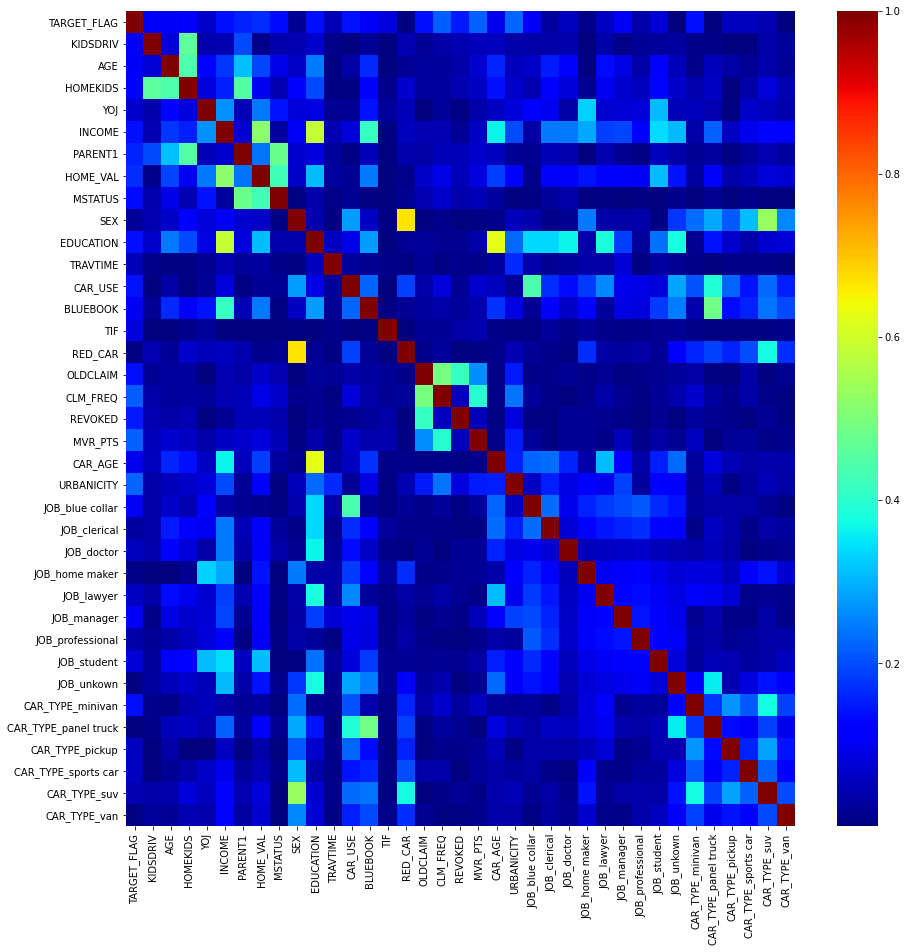

In [131]:
plt.figure(figsize=(15,15))
sns.heatmap(np.abs(prepare_data(clean_data(df)).corr(method='pearson')), cmap="jet")
plt.show()

The correlation matrix confirms that TARGET_FLAG is not particularly correlated with any column, except with TARGET_AMT as TARGET_FLAG is 0 when TARGET_AMT is O and 1 when TARGET_AMT is positive.
Also, there is no appearence of columns that are very correlated, thus there seems to be no redundant information.

##### Reload and shuffle the dataset, then get the CV indeces

In [6]:
# reload train dataframe
df = pd.read_csv("data/train_auto.csv", index_col=0)
print('df shape :', df.shape)

def get_cv_indeces(df, k_cv = 5):
    '''
    return a list of tuples (indeces_train, indeces_val), each tuple correspond to a split for cross validation
    k_cv (int) : defualt 5, the number folds for CV
    '''
    # randomly shuffle the row indeces of the df
    np.random.seed(42)
    list_index_df = list(df.index)
    list_shuffled_index_df = list_index_df.copy()
    np.random.shuffle(list_shuffled_index_df)
    #df = df.reindex(list_shuffled_index_df)


    # Cross validation indeces

    # split the shuffled indeces in five lists
    chunck_len = int(len(list_shuffled_index_df) / k_cv)
    cv_chunk_indeces_list = []
    for i in range(k_cv):
        cv_chunk_indeces_list.append(list_shuffled_index_df[i*chunck_len : (i+1)*chunck_len])
    # create a list of  tuples (indeces_train, indeces_val) based on the previous split
    cv_indeces = []
    for i in range(k_cv):
        indeces_train = []
        for j in range(k_cv):
            if j==i:
                indeces_val = cv_chunk_indeces_list[j]
            else:
                indeces_train += cv_chunk_indeces_list[j]
        cv_indeces.append((indeces_train, indeces_val))
    return cv_indeces


df shape : (8161, 25)


### Training

Let's train different classifiers and compare how they perform with cross validation. Tree based classifiers will be trained on all columns. Logisitic regression will be tried on numerical data only. In order to handle the label imbalance, an option is implemented to use SMOTE oversampling on the minority class

##### Performance evaluation function

The labels are imbalanced, accuracy is not adapted to this setting. We want to asses the ability of the classifier to correctly find the minorty class 1. The prefered metrics is the f1 score related to the 'TARGET_FLAG' = 1

In [62]:
def compute_scores(y_true, y_pred):
    '''
    Compute the F1 score, recall, precision and accuracy 
    '''
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='binary', pos_label= 1)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return recall, precision, f1, acc

# define data frame that will store all the results
df_performance = pd.DataFrame(columns=['model', 'encoding', 'f1 val', 'f1 train', 'recall val', 'precision val'])

##### Training function

In [18]:
def train_clf(df, cv_indeces, clf, oversampling = True):
    '''
    Train a classifier and return scores
    df (pd.DataFrame)   : dataset
    cv_indeces (list)   : tuples containing the indeces to split data for cross validation
    clf                 : used classifier
    oversampling (bool) : when True, apply SMOTE oversampling to increase the number of samples belonging to the minority class in the training set
    '''
    f1_val_list, f1_train_list, recall_val_list, precision_val_list = [], [], [], [] 
    for i in range(len(cv_indeces)):
        X_train = df.loc[cv_indeces[i][0], :]
        X_val = df.loc[cv_indeces[i][1], :]

        # separate the labels from the data
        y_train = X_train.iloc[:, 0]
        y_val = X_val.iloc[:, 0]
        X_train = X_train.iloc[:, 1:]
        X_val = X_val.iloc[:, 1:]

        # oversample
        if oversampling:
            sm = SMOTE(random_state=42)
            X_train, y_train = sm.fit_resample(X_train, y_train)
            #print('nb 0', np.sum(np.array(y_train) == 0), 'nb 1', np.sum(np.array(y_train) == 1))

        # train
        clf.fit(X_train, y_train)
        # predict
        y_pred_train = clf.predict(X_train)
        y_pred_val = clf.predict(X_val)
        
        # add scores
        recall, precision, f1, acc = compute_scores(y_train, y_pred_train)
        f1_train_list.append(f1)
        recall, precision, f1, acc = compute_scores(y_val, y_pred_val)
        f1_val_list.append(f1)
        recall_val_list.append(recall)
        precision_val_list.append(precision)

    # append averaged metrics to the dic
    dic_score = {'f1 val' : 	np.mean(f1_val_list),
                'f1 train' : np.mean(f1_train_list),
                'recall val' : 	np.mean(recall_val_list),
                'precision val' : np.mean(precision_val_list)}
    return dic_score

##### Random forest

In [50]:
# define dataset
df_randomforest = prepare_data(clean_data(df, missing_values_method='replace'), method='encode')


# 5 fold CV, store metrics before averaging them
k_cv= 5
cv_indeces = get_cv_indeces(df_randomforest, k_cv = k_cv)

clf_dic = {'n_estimators' : [], 'max_depth' :[], 'criterion': [], 'min_samples_split': [], 'oversampling' : [], 'f1 val' : [], 'f1 train' : []}
max_f1_val = 0
idx_best = None
idx_loop = 0
for n_estimators in [20, 50, 80, 100, 150, 200 ]:
    for max_depth in [3, 5, 8, 10, 20]:
        for criterion in ['gini', 'entropy']:
            for min_samples_split in [2, 3, 4]:
                for oversampling in [True, False]:
                    # train clf
                    clf = RandomForestClassifier(n_estimators= n_estimators, max_depth=max_depth,criterion=criterion,
                                                 min_samples_split=min_samples_split, random_state=42)
                    dic_score = train_clf(df_randomforest, cv_indeces, clf, oversampling = oversampling)

                    # report scores
                    clf_dic['n_estimators'].append(n_estimators)
                    clf_dic['max_depth'].append(max_depth)
                    clf_dic['criterion'].append(criterion)
                    clf_dic['min_samples_split'].append(min_samples_split)
                    clf_dic['oversampling'].append(oversampling)
                    f1_val, f1_train = dic_score['f1 val'], dic_score['f1 train']
                    clf_dic['f1 val'].append(f1_val)
                    clf_dic['f1 train'].append(f1_train)

                    if f1_val > max_f1_val:
                        max_f1_val = f1_val
                        idx_best = idx_loop
                    idx_loop += 1
                    if idx_loop%50==0: print(idx_loop)
                    

pd.DataFrame(clf_dic).loc[idx_best]

50
100


/media/victor/USB/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/victor/USB/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/victor/USB/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


150
200
250
300
350


n_estimators              100
max_depth                   8
criterion                gini
min_samples_split           3
oversampling             True
f1 val               0.562728
f1 train             0.872554
Name: 206, dtype: object

In [63]:
# add the best to the performance df
clf = RandomForestClassifier(n_estimators=100, max_depth=8, criterion='gini', min_samples_split=3,  random_state=42)
dic_score = train_clf(df_randomforest, cv_indeces, clf, oversampling = True)

dic_score['model'] = 'Random forest'
dic_score['encoding'] = 'yes'
df_performance = df_performance.append(dic_score, ignore_index=True)

##### xgboost

In [ ]:
# define dataset
df_randomforest = prepare_data(clean_data(df, missing_values_method='replace'), method='encode')


# 5 fold CV, store metrics before averaging them
k_cv= 5
cv_indeces = get_cv_indeces(df_randomforest, k_cv = k_cv)

xgb_dic = {'n_estimators':[], 'max_depth' : [], 'eta' : [],'min_child_weight' : [],  'oversampling' : [], 'f1 val' : [], 'f1 train' : []}
max_f1_val = 0
idx_best = None
idx_loop = 0
for n_estimators in [20, 50, 80, 100, 150, 200]:
    for max_depth in [3, 5, 8, 10]:
        for eta in [0.05, 0.2, 0.3]:
            for min_child_weight in [1, 2]:
                for oversampling in [True, False]:
                    # train clf
                    clf = xgb.XGBClassifier(n_estimators=n_estimators,max_depth=max_depth,
                                            eta=eta, min_child_weight=min_child_weight, 
                                             use_label_encoder=False, random_state=42)
                    
                    dic_score = train_clf(df_randomforest, cv_indeces, clf, oversampling = oversampling)

                    # report scores
                    xgb_dic['n_estimators'].append(n_estimators)
                    xgb_dic['max_depth'].append(max_depth)
                    xgb_dic['eta'].append(eta)
                    xgb_dic['min_child_weight'].append(min_child_weight)
                    xgb_dic['oversampling'].append(oversampling)
                    f1_val, f1_train = dic_score['f1 val'], dic_score['f1 train']
                    xgb_dic['f1 val'].append(f1_val)
                    xgb_dic['f1 train'].append(f1_train)

                    if f1_val > max_f1_val:
                        max_f1_val = f1_val
                        idx_best = idx_loop
                    idx_loop += 1
                    if idx_loop%50==0: print(idx_loop)
                

pd.DataFrame(xgb_dic).loc[idx_best]

In [47]:
pd.DataFrame(xgb_dic).loc[idx_best]

n_estimators              50
max_depth                  3
eta                      0.2
min_child_weight           2
oversampling            True
f1 val              0.564931
f1 train            0.864921
Name: 54, dtype: object

In [64]:
# add the best to the performance df
clf = xgb.XGBClassifier(n_estimators=50,max_depth=3, eta=0.2, min_child_weight=2, 
                        use_label_encoder=False, random_state=42)
dic_score = train_clf(df_randomforest, cv_indeces, clf, oversampling = False)

dic_score['model'] = 'Xgboost'
dic_score['encoding'] = 'yes'
df_performance = df_performance.append(dic_score, ignore_index=True)  

[22:54:13] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:54:14] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:54:15] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:54:16] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: 

#### AdaBoost

In [46]:
# define dataset
df_randomforest = prepare_data(clean_data(df, missing_values_method='replace'), method='encode')


# 5 fold CV, store metrics before averaging them
k_cv= 5
cv_indeces = get_cv_indeces(df_randomforest, k_cv = k_cv)

ada_dic = {'n_estimators':[], 'learning_rate' : [], 'algorithm' : [], 'oversampling' : [], 'f1 val' : [], 'f1 train' : []}
max_f1_val = 0
idx_best = None
idx_loop = 0
for n_estimators in [20, 30, 50, 80]:
    for learning_rate in [0.1, 0.5, 1, 2]:
        for algorithm in ['SAMME', 'SAMME.R']:
            for oversampling in [True, False]:
                # train clf
                clf = AdaBoostClassifier(n_estimators=n_estimators,learning_rate=learning_rate,
                                        algorithm=algorithm, random_state=42)
                
                dic_score = train_clf(df_randomforest, cv_indeces, clf, oversampling = oversampling)

                # report scores
                ada_dic['n_estimators'].append(n_estimators)
                ada_dic['learning_rate'].append(learning_rate)
                ada_dic['algorithm'].append(algorithm)
                ada_dic['oversampling'].append(oversampling)
                f1_val, f1_train = dic_score['f1 val'], dic_score['f1 train']
                ada_dic['f1 val'].append(f1_val)
                ada_dic['f1 train'].append(f1_train)

                if f1_val > max_f1_val:
                    max_f1_val = f1_val
                    idx_best = idx_loop
                idx_loop += 1
                if idx_loop%50==0: print(idx_loop)
                

pd.DataFrame(ada_dic).loc[idx_best]

/media/victor/USB/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/victor/USB/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/victor/USB/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/victor/USB/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classi

50


n_estimators           80
learning_rate         0.5
algorithm         SAMME.R
oversampling         True
f1 val           0.573517
f1 train         0.844304
Name: 54, dtype: object

In [48]:
pd.DataFrame(ada_dic).loc[idx_best]

n_estimators           80
learning_rate         0.5
algorithm         SAMME.R
oversampling         True
f1 val           0.573517
f1 train         0.844304
Name: 54, dtype: object

In [65]:
# add the best to the performance df
clf = AdaBoostClassifier(n_estimators=80,learning_rate=0.5,
                                        algorithm='SAMME.R', random_state=42)
dic_score = train_clf(df_randomforest, cv_indeces, clf, oversampling = True)

dic_score['model'] = 'Adaboost'
dic_score['encoding'] = 'yes'
df_performance = df_performance.append(dic_score, ignore_index=True)  

##### Logistic regression

In [34]:
# define dataset
df_randomforest = prepare_data(clean_data(df, missing_values_method='replace'), method='numerical')


# 5 fold CV, store metrics before averaging them
k_cv= 5
cv_indeces = get_cv_indeces(df_randomforest, k_cv = k_cv)

logistic_dic = {'penalty':[], 'oversampling' : [], 'f1 val' : [], 'f1 train' : []}
max_f1_val = 0
idx_best = None
idx_loop = 0
for penalty in [ 'l2', 'none']:
    for oversampling in [True, False]:
        # train clf
        clf = LogisticRegression(penalty=penalty, random_state=42)
        dic_score = train_clf(df_randomforest, cv_indeces, clf, oversampling = oversampling)

        # report scores
        logistic_dic['penalty'].append(penalty)
        logistic_dic['oversampling'].append(oversampling)
        f1_val, f1_train = dic_score['f1 val'], dic_score['f1 train']
        logistic_dic['f1 val'].append(f1_val)
        logistic_dic['f1 train'].append(f1_train)

        if f1_val > max_f1_val:
            max_f1_val = f1_val
            idx_best = idx_loop
        idx_loop += 1
        if idx_loop%50==0: print(idx_loop)
                

pd.DataFrame(logistic_dic).loc[idx_best]

penalty               l2
oversampling        True
f1 val          0.444014
f1 train        0.593435
Name: 0, dtype: object

In [66]:
# add the best to the performance df
clf = LogisticRegression(penalty='l2', random_state=42)
dic_score = train_clf(df_randomforest, cv_indeces, clf, oversampling = True)

dic_score['model'] = 'Logistic regression'
dic_score['encoding'] = 'numerical'
df_performance = df_performance.append(dic_score, ignore_index=True)

#### Results

In [67]:
df_performance

,model,encoding,f1 val,f1 train,recall val,precision val
0,Random forest,yes,0.562728,0.872554,0.543496,0.584282
1,Xgboost,yes,0.523140,0.582953,0.426766,0.676688
2,Adaboost,yes,0.573517,0.844304,0.563788,0.583611
3,Logistic regression,numerical,0.443374,0.594235,0.578541,0.364665


 The best performance regarding f1 score is achieved with Adaboost. The predictions will be generated using this model. 
 We can note that other classifiers perform better from a recall or a precision perspective. Adaboost is the best at balancing the two metrics.

### Inference

#### Check if the missing values are present in the same columns as before

df shape : (2141, 25)


,nb of NaN
TARGET_FLAG,2141
TARGET_AMT,2141
KIDSDRIV,0
AGE,1
HOMEKIDS,0
YOJ,94
INCOME,125
PARENT1,0
HOME_VAL,111
MSTATUS,0


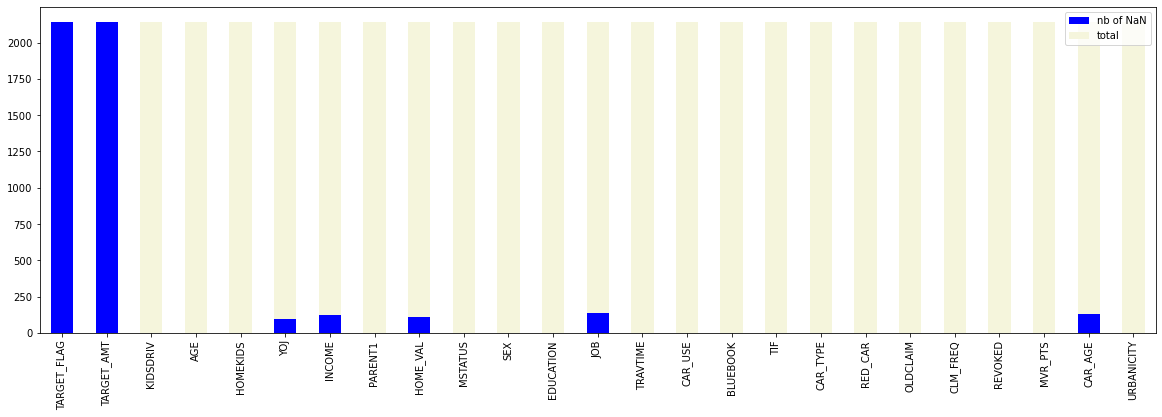

In [68]:
# load test dataset
df_test = pd.read_csv("data/test_auto.csv", index_col=0)
print('df shape :', df_test.shape)

#### plot the number of missing values per column
col_na_count = []
col_no_na_count = []
for col in df_test.columns:
    col_na_count.append(df_test[col].isna().sum())
    col_no_na_count.append(len(df_test[col]) - df_test[col].isna().sum())

missing_values_df = pd.DataFrame({'nb of NaN' : col_na_count, 'total' : col_no_na_count}, index=df_test.columns)
missing_values_df.plot.bar(stacked=True, figsize=(20, 6), color={'total' : 'beige', 'nb of NaN' : 'blue'})
pd.DataFrame(missing_values_df['nb of NaN'])

The missing values are present in the same columns as in the training data.

##### Inference and csv generation

In [70]:
# best classifier definition
best_clf = AdaBoostClassifier(n_estimators=80,learning_rate=0.5,
                                        algorithm='SAMME.R', random_state=42)

# prepare and shuffle train
df_train = prepare_data(clean_data(df, missing_values_method='replace'), method='encode')
np.random.seed(42)
list_index_df = list(df_train.index)
list_shuffled_index_df = list_index_df.copy()
np.random.shuffle(list_shuffled_index_df)
df_train = df_train.reindex(list_shuffled_index_df)

# prepare test
df_pred = prepare_data(clean_data(df_test, missing_values_method='replace'), method='encode')

# define stes
y_train = df_train.iloc[:, 0]
X_train = df_train.iloc[:, 1:]
X_test = df_pred.iloc[:, 1:]

# train and pred
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)


# add the predictions to the test df
df_test['TARGET_FLAG'] = y_pred
# save to csv
df_test.to_csv('test_pred.csv')